# DS-GA 3001.001 Special Topics in Data Science: Probabilistic Time Series Analysis

# Gaussian Processes

$$GP(\mu(x), K(x_1, x_2))$$

mean usually to $\mu(x)=0$

structure defined through covariance $K(x_1, x_2)$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import time
np.random.seed(12)

## Part I: Data Generation

Visualization functions

In [2]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()

Various generative functions for GP to approximate.

Here we assume that y = 0 when x = 0.

In [3]:
def linear_func(x):
    return 1.2 * x

def sin_wave(x):
    return np.sin(0.9*x).flatten()

Generate train and test data.

In [4]:
x_min = -10
x_max = 10
n_train = 50
generative_func = sin_wave

# X2: we want x in the range of (x_min, x_max)
all_x = np.arange(x_min, x_max, step=0.1)
# Y2: this is the true values of f(x) for x in (x_min, x_max)
# (we are NOT using them to train GP. true_y is only used for evaluation)
true_y = generative_func(all_x)
# X1, Y1: a randomly given training set of: n_train training points
X_train = np.random.uniform(x_min, x_max, n_train)
beta_inv = .01
# noisy data points
y_train = generative_func(X_train)+np.random.randn(len(X_train))*np.sqrt(beta_inv)

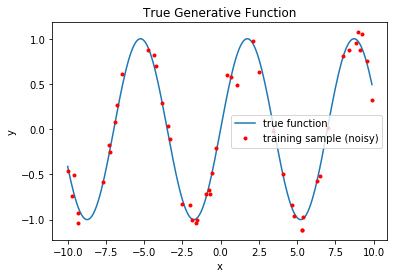

In [5]:
plt.figure()
plt.plot(all_x, true_y, label='true function')
plt.plot(X_train, y_train, '.r', label='training sample (noisy)')
plt.title("True Generative Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## Part II GP with sklearn

Sklearn has a very handy API for Gaussian Process regression. 

http://scikit-learn.org/stable/modules/gaussian_process.html

### Kernel functions
Kernels to parametrize covariance structure

Constant Kernel: covariance is defined by a constant value

RBF (squared exponential) Kernel: $$K(x_m, x_n)=exp\left(-\frac{||x_m-x_n||^2}{2*l^2}\right)$$

White Kernel: accords for noise-component
$$K(x_m, x_n)=noise$$ 
where if $x_m=x_n$ else $0$



In [6]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

There are plenty pre-built kernels defined by the API. Moreover, you can construct you own kernels by combining the pre-built ones.

In [7]:
kernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5)) + RBF(length_scale=2) + WhiteKernel(noise_level=1)

Text(0.5, 1.0, 'kernel pre-fitting')

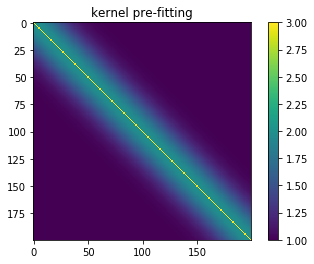

In [8]:
plt.figure()
plt.imshow(kernel(np.array([all_x]).T))
plt.colorbar()
plt.title('kernel pre-fitting')

#### fitting the GP model

The fit() method automatically selects the hyper-parameters of given kernels.

In [9]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + RBF(length_scale=2) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

0.00316**2 + RBF(length_scale=2.02) + WhiteKernel(noise_level=0.011)


Text(0.5, 1.0, 'kernel post-fitting')

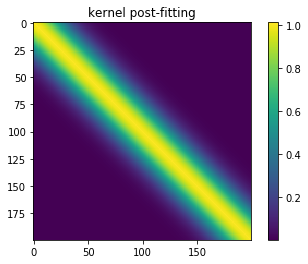

In [10]:
# print the kernel with fitted parameters
print(gp.kernel_)
plt.figure()
plt.imshow(gp.kernel_(np.array([all_x]).T))
plt.colorbar()
plt.title('kernel post-fitting')

#### prediction of new values

The predict method returns both mean and std.

In [11]:
mus, sigmas = gp.predict(all_x.reshape(-1,1), return_std=True)

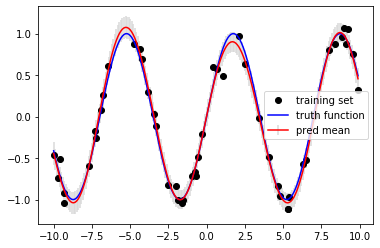

In [12]:
plot_gp(all_x, mus, sigmas, X_train, y_train, true_y=true_y)

below we will use this form of the Squared Exponential Kernel:

$$k(x,x') = \sigma^2 exp(-\frac{(x - x')^2}{2 l^2})$$

In [26]:
def exponential_cov(x, y, params):
    """
    Function that implements the squared exponential kernel
    """
    sigma, l = params
    return np.power(sigma,2) * np.exp( - np.subtract.outer(x, y)**2/(2 * np.power(l,2)))

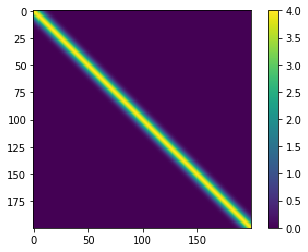

In [27]:
plt.figure()
plt.imshow(exponential_cov(all_x, all_x, (2,.5)))
plt.colorbar()

## Part III: GP Inference

In this part, we implement the predict_cholesky function.

*(Bishop chapter 6.4 on Gaussian Processes)*

### noisy observations

- in our training data the true generative function is hidden by Gaussian noise

- we take this noise into account by expressing the observed target value as
$$t_n=y_n+\epsilon_n$$

where $y_n$ is the true function value of $y(x_n)$ and $\epsilon\sim N(0, \beta^{-1})$

- therefore the probability of an observation $t_n$ given $y_n$ is:

$$p(t_n|y_n)=N(t_n|y_n,\beta^{-1})$$

- marginalizing over the possible $y_n$ gives us the marginal distribution for the observation vector $\mathbf{t}$:

$$p(\mathbf{t})= N(0, C(x))$$
where $C$ is made up of the GP covariance and the noise variance: $$C(x_n, x_m)=K(x_n,x_m)+\beta^{-1}\delta_{nm}$$



### inference 
predict new data points/trajectories given fixed (noisy, observed) data points

define the probability for a new points $\mathbf{t}^{pred}$ given old observed values $\mathbf{t}^{train}$

$$p(\mathbf{t}^{pred}|\mathbf{t}^{train}) = N\left(\mu_{\mathbf{t}^{pred}|\mathbf{t}^{train}}, V_{\mathbf{t}^{pred}|\mathbf{t}^{train}}\right)$$

where
$$\mathbf{t}^{train}=y(\mathbf{x}^{train})+\mathbf{\epsilon}$$


#### remember Gaussian properties

Using Gaussian properties:
$$\left(
\begin{matrix}
z_1\\
z_2
\end{matrix}
\right)\sim N\left(\left[\begin{matrix}
a\\
b
\end{matrix}\right],\left[
\begin{matrix}
A & B\\
B^T & C
\end{matrix}
\right]\right)$$

translate this to our (observed/predicted) data points $\mathbf{t}$

$$p(\mathbf{t}^{train}, \mathbf{t}^{pred}) = N(0, \Sigma)$$

where 
$$\Sigma=\left[\begin{matrix}C^{train} & K \\ K^T & C^{pred}\end{matrix}\right]$$ 

where $K$ stands for $K(x_n, x_m)$

from this we get

$$p(\mathbf{t}^{pred}|\mathbf{t}^{train}) = N\left(\mu_{\mathbf{t}^{pred}|\mathbf{t}^{train}}, V_{\mathbf{t}^{pred}|\mathbf{t}^{train}}\right)$$

$$\mu_{\mathbf{t}^{pred}|\mathbf{t}^{train}} = K^T(C^{train})^{-1}\mathbf{t}^{train}$$
$$V_{\mathbf{t}^{pred}|\mathbf{t}^{train}} = C^{pred}-K^T(C^{train})^{-1}K$$


*Note that here, we assume zero mean*

### inference using the Cholesky Decomposition


- faster and more stable way to compute $\mu_{\mathbf{t}^{pred}|\mathbf{t}^{train}}$ and $V_{\mathbf{t}^{pred}|\mathbf{t}^{train}}$ given that $(C^{train})^{-1}$ is not guaranteed to be non-singular

- The Cholesky decomposition converts a (Hermitian, positive-definite) matrix $A$ into the product of a lower triangular matrix $L$ and its conjugate transpose $L^*$

- We use the Cholesky decomposition to get $C^{train}=LL^T$

*Because our covariance matrix*  $(C^{train})^{-1}$ *is positive-definite and a real matrix that mirrors itself along the diagonal, it is a Hermitian matrix*

*L will be a real-value matrix so its conjugate is itself*

- From this we get:

$$\mu_{\mathbf{t}^{pred}|\mathbf{t}^{train}} = K^T(C^{train})^{-1}\mathbf{t}^{train} = K^T(LL^T)^{-1}\mathbf{t}^{train} = K^T(L^T)^{-1}L^{-1}\mathbf{t}^{train}=(L^{-1}K)^T(L^{-1}\mathbf{t}^{train})$$


$$V_{\mathbf{t}^{pred}|\mathbf{t}^{train}} = C^{pred}-K^T(C^{train})^{-1}K = C^{pred}-(L^{-1}K)^T(L^{-1}K)$$

*where L=cholesky(C)*

$L^{-1}K$ *and* $L^{-1}\mathbf{t}^{train}$ *can be obtained by solving the linear system* $Lx=K$ *and* $Lx=\mathbf{t}^{train}$ *using np.linalg.solve*

In [28]:
def predict(x_pred, X_train, y_train, kernel, kernel_params, cholesky=True, beta_inv = 0):
    """
    Top level wrapper function for GP prediction
    """
    if cholesky:
        return predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params, beta_inv)
    else:
        return predict_inverse(x_pred, X_train, y_train, kernel, kernel_params, beta_inv)

def predict_inverse(x_pred, X_train, y_train, kernel, kernel_params, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    C = kernel(X_train, X_train, kernel_params) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, kernel_params)
    C_inv = np.linalg.inv(C)
    A = kernel(x_pred, x_pred, kernel_params) + np.eye(len(x_pred))*beta_inv
    mu = np.dot(B, C_inv).dot(y_train)
    cov = A - np.dot(B, C_inv).dot(B.T)    
    return mu, cov

def predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    ############################################
    ### TODO: please implement this function ###
    ######## (and replace current code) ########
    ############################################
    mu = np.zeros(len(x_pred))
    cov = np.eye(len(x_pred))
    return mu, cov

kernel_parameters = [2, 2]


### prediction giving varying number of training data points

Prior distribution

$$ y \sim N( \mu_0, \sigma_0^2) $$

Since we assume a zero mean function, we have $\mu_0 = E[y]=0$.

rmse = 0.7216677922512522


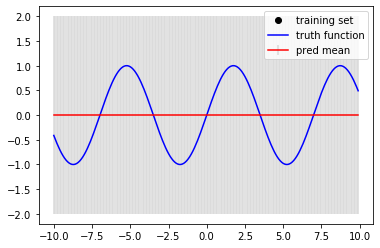

In [29]:
mu_0 = np.zeros(len(all_x))
sigma_0 = np.sqrt(exponential_cov(0, 0, kernel_parameters))
plot_gp(all_x, mu_0, sigma_0, [], [], true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mu_0, true_y))))

Posterior Distribution - single points

Now we start by feeding our GP with a single datum.

In [30]:
cholesky = True

rmse = 0.7216677922512522


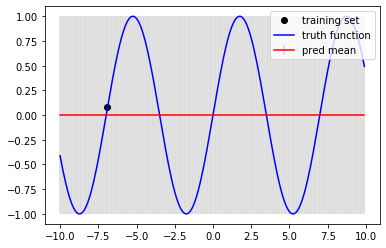

In [31]:
training_data_num = 1
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

With 10 points

rmse = 0.7216677922512522


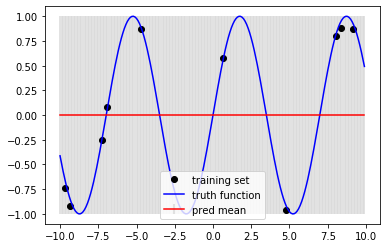

In [32]:
training_data_num = 10
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

With 20 points

rmse = 0.7216677922512522


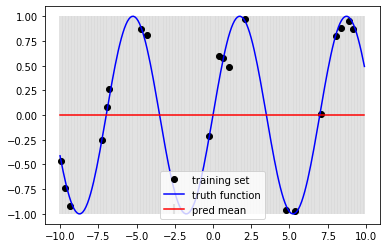

In [33]:
training_data_num = 20
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

50 points

rmse = 0.7216677922512522


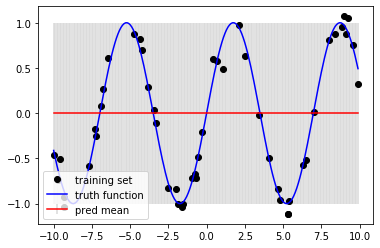

In [34]:
training_data_num = 50
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
mus, cov = predict(all_x, need_X_train, need_y_train, exponential_cov, kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format( np.sqrt(mean_squared_error(mus, true_y))))

## Part IV: Sampling

For this part, we implement the sample_cholesky function.

### sampling from multivariate Gaussian

use property of multivariate Gaussian where if $z\sim N(0,I)$ then $x=\mu+Lz$ gives $x\sim N(\mu, LL^T)$ where $L=cholesky(LL^T)$

In [35]:
def sample_cholesky(mu, cov, n_points, n_samples):
    """
    Function that performs sampling from multi-variate Gaussian using Cholesky Decomposition
    @param mu: a numpy array of size n
    @param cov: a numpy matrix of size n*n
    @param n_points: how many points per sample
    @param n_samples: how many samples
    @return a numpy matrix with dimension (n_points, n_samples)
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    return np.zeros([n_points, n_samples])

Sample from prior

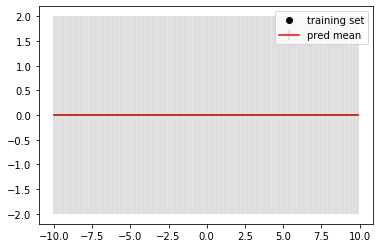

In [36]:
training_data_num = 0
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

Sample from posterior with 10 points

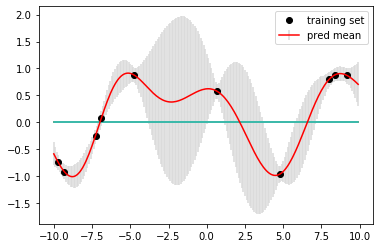

In [37]:
training_data_num = 10
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

Sample from posterior with 30 points

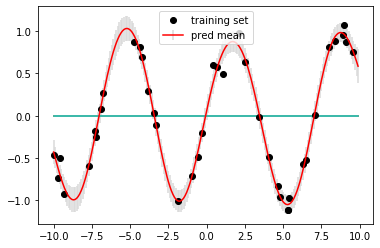

In [38]:
training_data_num = 40
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

### What if observation noise is assumed to be 0
(this part is not graded)

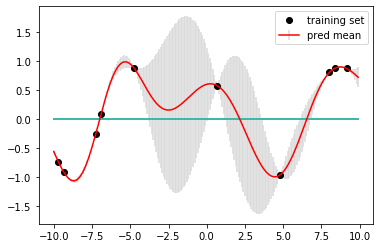

In [39]:
training_data_num = 10
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=0)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

### Please turn in the code before 11/13/2020 at 11:59 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. 